In [2]:
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.0-py3-none-any.whl size=185329 sha256=7d5bf82ee574a6f46f17c2194f24d63fc241d5b5f09a6da67932e778b6c41790
  Stored in directory: /root/.cache/pip/wheels/36/8e/e2/e932956b10b843eb6be9eefa70b5c1bee7b561be14c423b136
Successfully built pyod


In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from pyod.utils.data import generate_data, get_outliers_inliers
from sklearn.ensemble import IsolationForest

In [4]:
# Data Loading
X, Y = generate_data(behaviour='new', n_features=10,
                     train_only=True,
                     contamination=0.1,
                     random_state=2023)

In [5]:
# Naming for columns
col_list = []
for i in range(X.shape[1]):
    a = 'X{}'.format(i+1)
    col_list.append(a)

In [6]:
# Make DF
df = pd.DataFrame(X, columns = col_list)
df['Y'] = Y

Text(0.5, 1.0, 'Ground Truth')

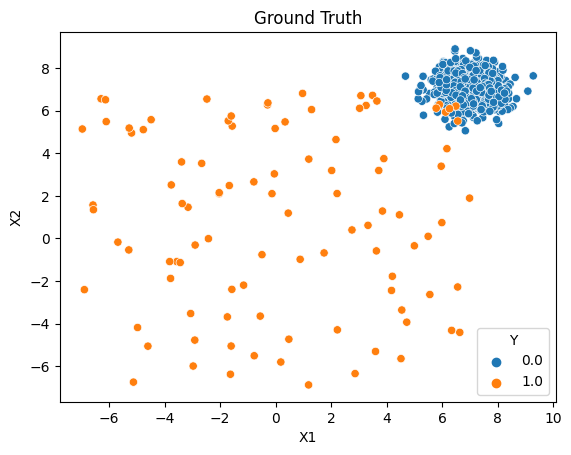

In [7]:
# Data 분포 확인하기 X1, X2
sns.scatterplot(x='X1', y='X2', hue='Y', data=df);
plt.title('Ground Truth')

## [Isolation Forest Parameter]
  - package : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
  - n_estimators : 원하는 기본 estimators 수, default=100
  - max_samples : 하나의 estimator에 들어가는 sample 수(int or float)
      - If int, then draw max_samples samples.
      - If float, then draw max_samples * X.shape[0] samples.
      - If “auto”, then max_samples=min(256, n_samples).
      - default='auto'
  - contamination : 데이터 세트 내 이상치 개수 비율('auto' or float)
      - default='auto'
  - max_features : estimator의 최대 columns 수(int or float), default=1.0
      - If int, then draw max_features features.
      - If float, then draw max(1, int(max_features * n_features_in_)) features.
      - default=1.0
  - bootstrap : 데이터 중복(bootstrap)할 것인지 여부(boolean),
      - default=False
      - 이상치가 안 뽑힐 수 있기 때문에 추천하지 않음

In [10]:
# Isolation Forest Setup
IF = IsolationForest(n_estimators = 150, max_samples = 500, contamination = 0.1)
IF.fit(df[['X1', 'X2']])
y_pred = IF.predict(df[['X1', 'X2']])

for i in range(y_pred.shape[0]):
    if y_pred[i] == 1:
        y_pred[i] = 0
    else:
        y_pred[i] = 1

n_errors = (y_pred != df['Y']).sum()

In [11]:
n_errors

14

In [12]:
# Opposite of the anomaly score defined in the original paper.
X_scores = IF.score_samples(df[['X1', 'X2']])

In [13]:
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())

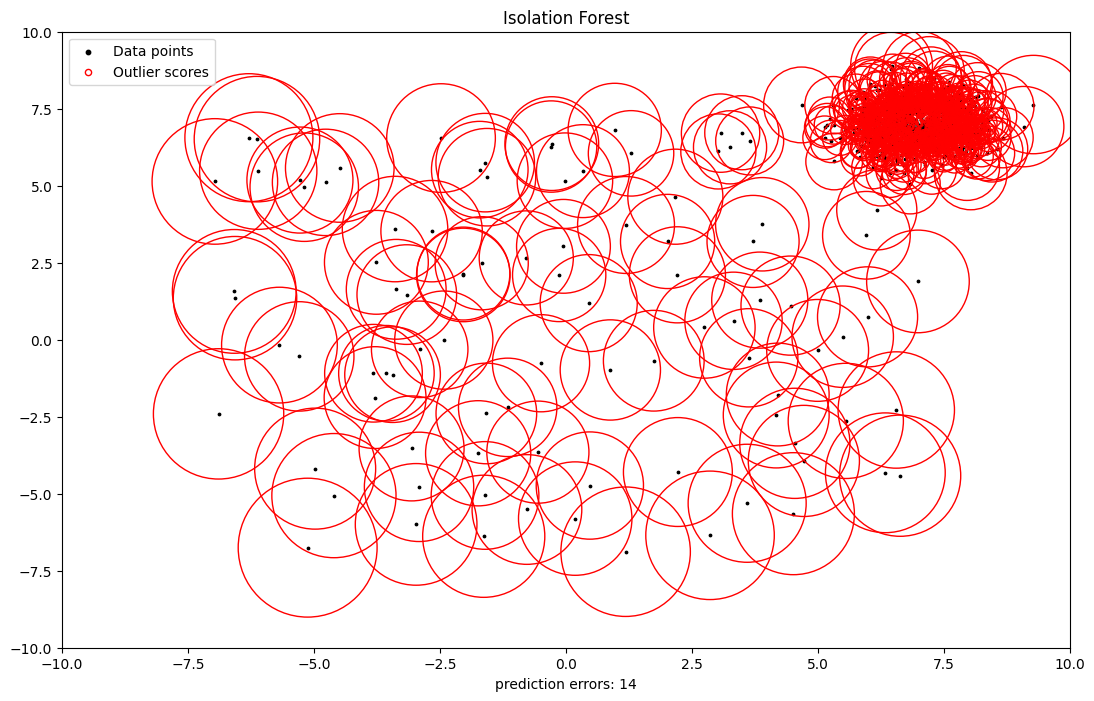

In [14]:
plt.figure(figsize=(13,8))
plt.title("Isolation Forest")
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], color="k", s=3.0, label="Data points")
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(
    df.iloc[:, 0],
    df.iloc[:, 1],
    s=10000 * radius**2,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
plt.xlim((-10, 10))
plt.ylim((-10, 10))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

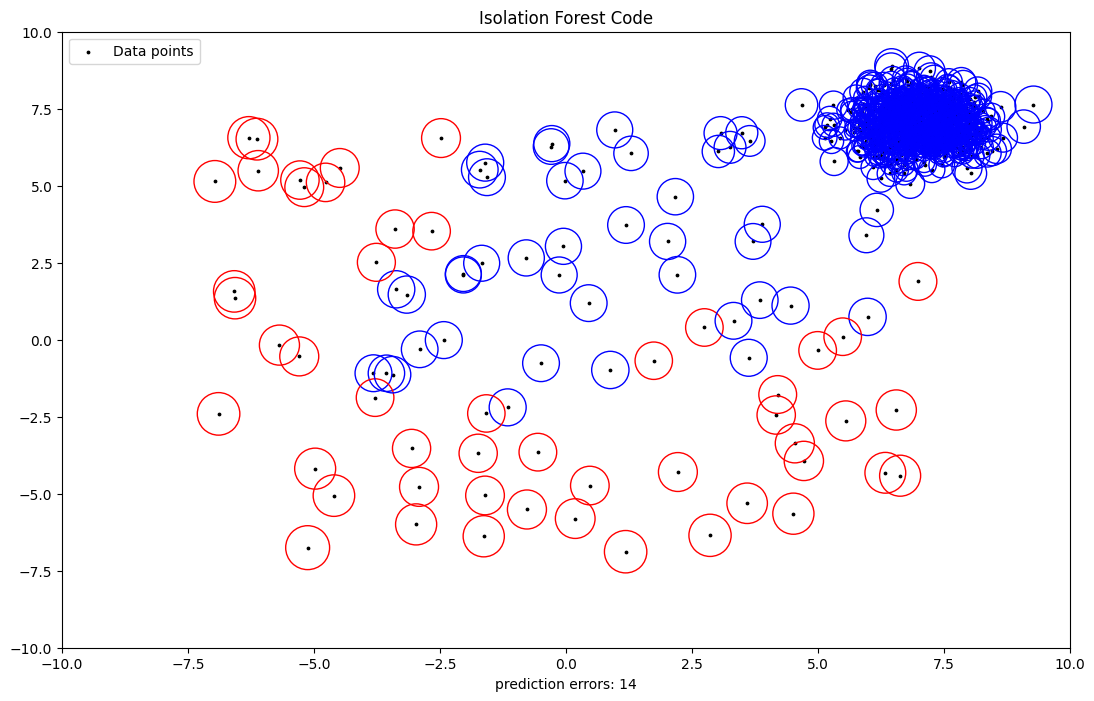

In [15]:
plt.figure(figsize=(13,8))
plt.title("Isolation Forest Code")
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], color="k", s=3.0, label="Data points")
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min()) # MinMax Scale

for i in range(df.shape[0]):
    if radius[i] >= np.percentile(radius, 95):
            plt.scatter(
            df.iloc[i, 0],
            df.iloc[i, 1],
            s=1000 * radius[i],
            edgecolors="r",
            facecolors="none",
            #label="Outlier scores",
        )
    elif radius[i] < np.percentile(radius, 95):
            plt.scatter(
            df.iloc[i, 0],
            df.iloc[i, 1],
            s=1000 * radius[i],
            edgecolors="b",
            facecolors="none",
            #label="Outlier scores",
        )

plt.axis("tight")
plt.xlim((-10, 10))
plt.ylim((-10, 10))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc="upper left")
#legend.legendHandles[0]._sizes = [10]
#legend.legendHandles[1]._sizes = [20]
plt.show()

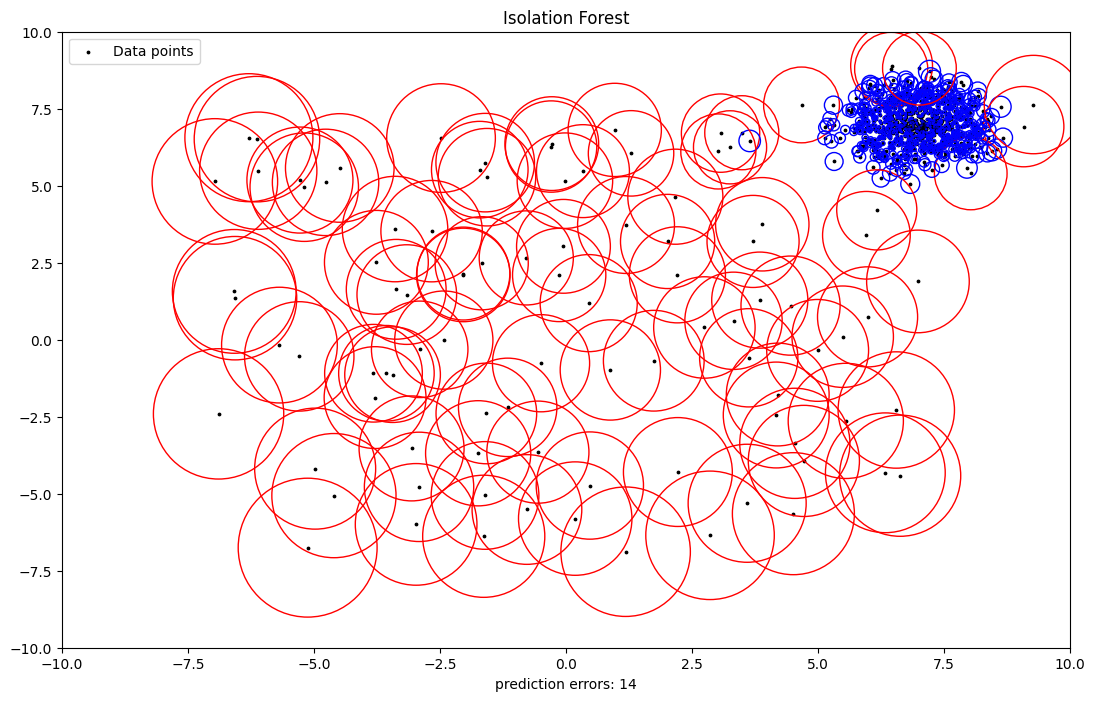

In [16]:
plt.figure(figsize=(13,8))
plt.title("Isolation Forest")
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], color="k", s=3.0, label="Data points")
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min()) # MinMax Scale

for i in range(df.shape[0]):
    if y_pred[i] == 1:
            plt.scatter(
            df.iloc[i, 0],
            df.iloc[i, 1],
            s=10000 * radius[i]**2,
            edgecolors="r",
            facecolors="none",
            #label="Outlier scores",
        )
    elif y_pred[i] == 0:
            plt.scatter(
            df.iloc[i, 0],
            df.iloc[i, 1],
            s=1000 * radius[i]**2,
            edgecolors="b",
            facecolors="none",
            #label="Outlier scores",
        )

plt.axis("tight")
plt.xlim((-10, 10))
plt.ylim((-10, 10))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc="upper left")
#legend.legendHandles[0]._sizes = [10]
#legend.legendHandles[1]._sizes = [20]
plt.show()

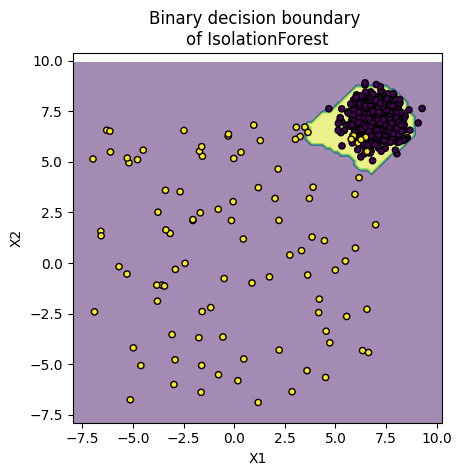

In [17]:
from sklearn.inspection import DecisionBoundaryDisplay

disp = DecisionBoundaryDisplay.from_estimator(
    IF,
    df[['X1','X2']],
    response_method="predict",
    alpha=0.5,
)
disp.ax_.scatter(df.iloc[:, 0], df.iloc[:, 1], c=df.iloc[:, -1], s=20, edgecolor="k")
disp.ax_.set_title("Binary decision boundary \nof IsolationForest")
plt.axis("square")
plt.show()